# NLP - Assignment 2

## Imports

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from FuzzyTM import FLSA_W
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import gensim
from gensim import corpora



c:\Users\charl\anaconda3\envs\nlp-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [3]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv("./us_equities_news_dataset.csv")
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [4]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]


In [5]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, 
                    remove_punctuation=True, 
                    remove_stopwords=True, 
                    lemmatize=False, 
                    stem=False, 
                    remove_short_words=False, 
                    remove_rare_words=False, 
                    remove_numbers=True, 
                    min_word_length=2):
    """
    Advanced preprocessing function that applies different levels of text processing.
    
    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - stem: Whether to apply stemming to reduce words to their base form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_rare_words: Whether to remove rare words based on the dataset distribution.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.
    
    Returns:
    - Preprocessed text as tokens.
    """
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]
    
    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Stemming (alternative to lemmatization)
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]
    
    return tokens

In [6]:
# Concatenate title and content columns
nvidia_dataset['content'] = nvidia_dataset['title'] + ' ' + nvidia_dataset['content']

In [7]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.
    
    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').
    
    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """
    
    if version == 'v1':
        # Basic tokenization and lowercasing
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=False, remove_stopwords=False, 
            lemmatize=False, remove_numbers=False, stem=False, 
            remove_short_words=False
        ))
    
    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=False, remove_numbers=False, stem=False, 
            remove_short_words=False
        ))
    
    elif version == 'v3':
        # Advanced preprocessing with stemming, number removal, short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=False, stem=True, remove_numbers=True, 
            remove_short_words=True, min_word_length=2
        ))
    
    elif version == 'v4':
        # Full preprocessing with lemmatization instead of stemming, number removal, and short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=True, remove_numbers=True, stem=False, 
            remove_short_words=True, min_word_length=2
        ))
    
    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3', or 'v4'.")
    
    # Return the DataFrame with original and preprocessed content
    return nvidia_dataset


In [8]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with stemming
train_data_v4 = apply_preprocessing(nvidia_dataset, version='v4')  # Full preprocessing with lemmatizer

In [9]:
train_data_v1.head()

,id,ticker,title,category,content,release_date,provider,url,article_id,preprocessed_content
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,A Central Bank War Just Started And Its Good F...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,"[central, bank, war, started, good, stock, ecb..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch Nivida Could Be Falling 6 S...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,"[stock, watch, nivida, could, falling, stock, ..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Stocks Dow Drops Nearly 400 Points as Apple ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,"[stock, dow, drop, nearly, point, apple, lead,..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,The Zacks Analyst Blog Highlights Advanced Mi...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,"[zacks, analyst, blog, highlight, advanced, mi..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,The Best Of CES 2020 Revised With 4 500 comp...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,"[best, ce, revised, company, bringing, innovat..."


In [10]:
# train_data_head = train_data_v1.head()

# # Specify the filename for the Excel file
# output_file = 'train_data_v1_head.xlsx'

# # Save to Excel
# train_data_head.to_excel(output_file, index=False)

# Helper functions

In [11]:
def compute_coherence_values_lda(train_data_list, dictionary, max_topics=20):
    """
    Compute coherence values for different numbers of topics in LDA model.

    Parameters:
    - train_data_list: List of tokenized documents.
    - dictionary: Gensim dictionary.
    - max_topics: Maximum number of topics to test.

    Returns:
    - coherence_values: List of coherence values for each number of topics.
    - optimal_num_topics: The optimal number of topics based on maximum coherence.
    """

    # Create Document-Term Matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list]

    coherence_values = []
    
    # Iterate over different numbers of topics
    for num_topics in range(2, max_topics + 1):
        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        # Compute coherence score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=train_data_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    # Find the optimal number of topics (maximum coherence)
    optimal_num_topics = coherence_values.index(max(coherence_values)) + 2  # +2 because range starts from 2

    return coherence_values, optimal_num_topics

In [12]:
def plot_coherence_scores_lda(coherence_values, max_topics):
    """
    Plot the coherence scores to visualize the elbow method.

    Parameters:
    - coherence_values: List of coherence values.
    - max_topics: Maximum number of topics tested.
    """
    x = range(2, max_topics + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, coherence_values, marker='o')
    plt.title('Coherence Scores vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(x)
    plt.grid()
    plt.show()

## Train Topic Models

In [13]:
def train_topic_model(train_data, model_type='LDA', max_topics=20):
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: list of str, the text to train the model on
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - num_topics: int, the number of topics to generate

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    """

    train_data_list_string = [' '.join(tokens) for tokens in train_data['preprocessed_content']]
    train_data_list_tokens = train_data['preprocessed_content'].tolist()  # This should already be a list of lists


    if model_type == 'LDA':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)
        
        # Compute coherence values and find optimal number of topics
        coherence_values, optimal_num_topics = compute_coherence_values_lda(train_data_list_tokens, dictionary, max_topics)

        # Plot coherence scores
        plot_coherence_scores_lda(coherence_values, max_topics)

        # Create Document-Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list_tokens]

        # Train LDA model with optimal number of topics
        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=optimal_num_topics,
            id2word=dictionary,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        # Get topics (top words in each topic)
        topics = lda_model.print_topics(num_words=10)

        return lda_model, topics
    
    elif model_type == 'FLSA-W':
        # Tokenized input is passed directly to FLSA-W
        tokenized_data = [tokens for tokens in train_data['preprocessed_content']]

        # Initialize FLSA-W model with tokenized data directly
        flsa_w_model = FLSA_W(
            input_file=tokenized_data,  
            num_topics=10,      
            num_words=10                
        )
        
        # Train the FLSA-W model
        pwgt, ptgd = flsa_w_model.get_matrices()  # This trains the model

        # Get topics as words
        topics = flsa_w_model.show_topics(representation='words')

        return flsa_w_model, topics
    
    elif model_type == 'BERTopic':
        # Train BERTopic model
        topic_model = BERTopic(nr_topics=10)
        topics, _ = topic_model.fit_transform(train_data_list_string)
        
        return topic_model, topics
    
    else:
        raise ValueError("Invalid model_type. Choose from 'LDA', 'FLSA-W', 'BERTopic'.")

## Iteration 1

In [14]:
def print_bertopic_topics(topic_model):
    """
    Print topics generated by BERTopic.
    
    Parameters:
    - topic_model: the trained BERTopic model
    """
    topics = topic_model.get_topics()
    for topic_num, words in topics.items():
        # Ignore the '-1' topic, which is typically noise in BERTopic
        if topic_num == -1:
            continue
        print(f"Topic {topic_num}: {', '.join([word[0] for word in words])}")


### LDA

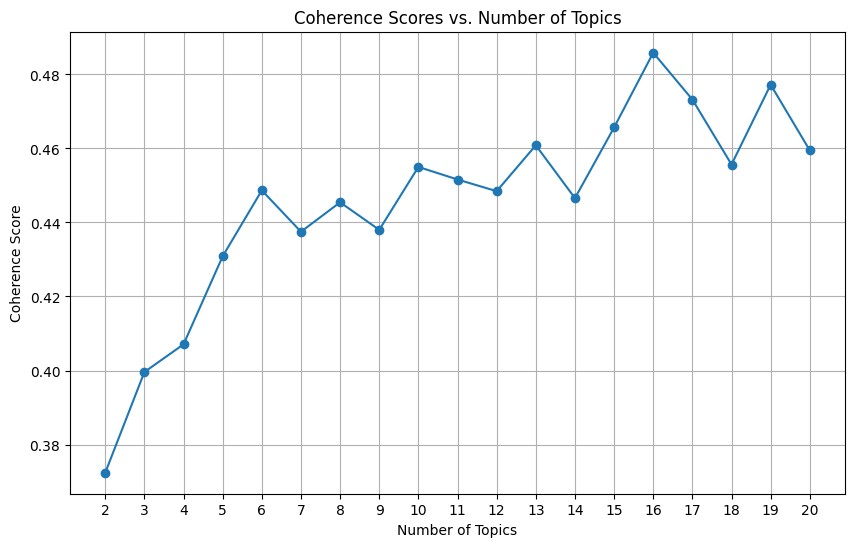

(0, '0.011*"stock" + 0.008*"market" + 0.006*"company" + 0.006*"time" + 0.006*"like" + 0.006*"day" + 0.005*"one" + 0.005*"tech" + 0.005*"nasdaq" + 0.004*"trading"')
(1, '0.013*"market" + 0.011*"week" + 0.009*"year" + 0.007*"could" + 0.007*"last" + 0.006*"rate" + 0.006*"investor" + 0.006*"might" + 0.006*"fed" + 0.005*"month"')
(2, '0.022*"year" + 0.022*"stock" + 0.017*"earnings" + 0.016*"industry" + 0.015*"zacks" + 0.014*"estimate" + 0.013*"nasdaq" + 0.011*"share" + 0.011*"company" + 0.010*"investor"')
(3, '0.035*"nvidia" + 0.016*"amd" + 0.015*"year" + 0.013*"share" + 0.012*"chip" + 0.012*"revenue" + 0.012*"intel" + 0.010*"company" + 0.010*"gaming" + 0.010*"analyst"')
(4, '0.015*"company" + 0.011*"technology" + 0.011*"nasdaq" + 0.009*"intel" + 0.009*"driving" + 0.008*"car" + 0.008*"nvidia" + 0.006*"new" + 0.006*"also" + 0.006*"apple"')
(5, '0.015*"china" + 0.011*"said" + 0.010*"percent" + 0.008*"trade" + 0.007*"market" + 0.007*"company" + 0.007*"billion" + 0.006*"year" + 0.006*"trump" + 

In [15]:
LDA_model, LDA_topics = train_topic_model(train_data_v1, model_type='LDA', max_topics=20)

# Print topics
for topic in LDA_topics:
    print(topic)

### FLSA-W

In [16]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics = train_topic_model(train_data_v1, model_type='FLSA-W', max_topics=10)

# Print topics
for topic in flsa_w_topics:
    print(topic)

['book', 'evolution', 'certainty', 'richard', 'synthesis', 'creativity', 'feynman', 'pretend', 'educator', 'professor']
['corporation', 'inc', 'broader', 'rise', 'com', 'gained', 'beat', 'led', 'fall', 'holding']
['gmt', 'settle', 'outnumbered', 'slumped', 'advancer', 'aug', 'vaneck', 'dax', 'unveils', 'mellanox']
['theory', 'mind', 'human', 'podcast', 'science', 'written', 'century', 'school', 'grand', 'old']
['supervisory', 'delisting', 'upnoteus', 'whileolympusshares', 'equitiesasian', 'stockbeat', 'reiterates', 'icera', 'marketpulse', 'bofaml']
['premarket', 'troy', 'smh', 'randewich', 'noel', 'kem', 'kemet', 'qrvo', 'staged', 'nellis']
['reuters', 'composite', 'chipmaker', 'hottest', 'jones', 'sporting', 'traded', 'combination', 'rose', 'lowest']
['ounce', 'unchanged', 'uncover', 'philadelphia', 'amat', 'esp', 'gainer', 'brent', 'greenback', 'inbox']
['stephen', 'jensen', 'shifted', 'biology', 'depend', 'regardless', 'pile', 'musk', 'attracted', 'served']
['nvda', 'nvidia', 'nyse'

In [17]:
# # Print the generated FLSA-W topics
# print("Initial FLSA-W Topics:")
# print_topics_lda(flsa_w_topics)

In [18]:
def compute_coherence_flsa_w(train_data, max_topics=10):
    """
    Compute coherence scores for FLSA-W model with varying number of topics.
    Parameters:
        - train_data: list of tokenized documents (preprocessed content).
        - max_topics: int, the maximum number of topics to test.
    Returns:
        - topic_nums: list of topic numbers used for testing.
        - coherence_scores: list of coherence scores for each number of topics.
    """
    
    tokenized_data = [tokens for tokens in train_data['preprocessed_content']]
    
    topic_nums = []
    coherence_scores = []
    
    # Try different numbers of topics
    for num_topics in range(3, max_topics + 1):
        # Train FLSA-W model
        flsa_w_model = FLSA_W(
            input_file=tokenized_data,  
            num_topics=num_topics,      
            num_words=10                
        )
        
        # Train the FLSA-W model
        flsa_w_model.get_matrices()  
        
        # Get the coherence score for the current model
        coherence_score = flsa_w_model.get_coherence_score() 
        print(f"Number of topics: {num_topics}, Coherence score: {coherence_score}")
        
        # Store the results
        topic_nums.append(num_topics)
        coherence_scores.append(coherence_score)
    
    return topic_nums, coherence_scores


def plot_elbow_curve(topic_nums, coherence_scores):
    """
    Create an elbow plot for the coherence scores vs. number of topics.

    Parameters:
    - topic_nums: list of number of topics tested.
    - coherence_scores: list of coherence scores for each number of topics.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(topic_nums, coherence_scores, marker='o')
    plt.title('FLSA-W Elbow Plot: Number of Topics vs Coherence Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

In [19]:
# Train the model and compute coherence scores
topic_nums, coherence_scores = compute_coherence_flsa_w(train_data_v1, max_topics=15)

Number of topics: 3, Coherence score: 0.3921555889125568
Number of topics: 4, Coherence score: 0.3941150494783054
Number of topics: 5, Coherence score: 0.4523960619322054
Number of topics: 6, Coherence score: 0.3851363192668869
Number of topics: 7, Coherence score: 0.4165684791647775
Number of topics: 8, Coherence score: 0.3848790394357928
Number of topics: 9, Coherence score: 0.3769917307957381
Number of topics: 10, Coherence score: 0.393215842333019
Number of topics: 11, Coherence score: 0.4020913627884269
Number of topics: 12, Coherence score: 0.3825624769398693
Number of topics: 13, Coherence score: 0.4143106009179043
Number of topics: 14, Coherence score: 0.37535956978581086
Number of topics: 15, Coherence score: 0.3882115675564781


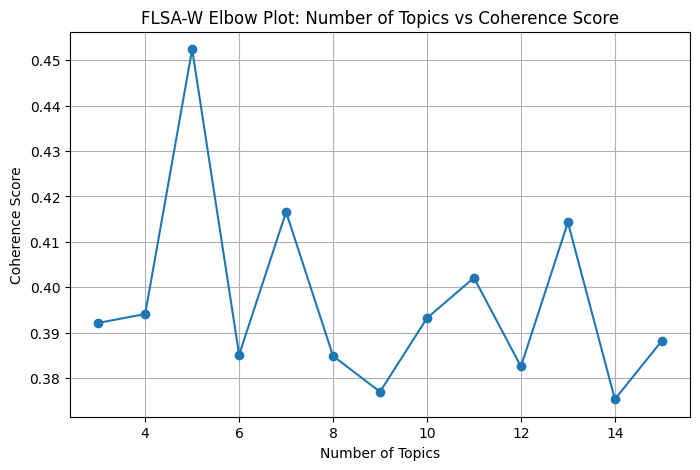

In [20]:
# Plot the elbow curve
plot_elbow_curve(topic_nums, coherence_scores)

### BERTopic

In [21]:
# Train BERTopic model on the first version of the preprocessed dataset
# num_topics is maximum number of topics rather than a fixed number of topics
bertopic_model, bertopic_topics = train_topic_model(train_data_v1, model_type='BERTopic', max_topics=10)



In [22]:
# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

BERTopic Topics:
Topic 0: stock, nasdaq, year, company, earnings, zacks, market, quarter, nyse, share
Topic 1: nvidia, amd, year, revenue, quarter, gaming, company, share, graphic, zacks
Topic 2: driving, car, vehicle, self, autonomous, nvidia, company, technology, tesla, said
Topic 3: traded, nvidia, day, seven, lowest, gmt, highest, exchange, volume, session
Topic 4: bitcoin, blockchain, etf, scenario, currency, cryptocurrency, target, oil, market, cryptocurrencies
Topic 5: facebook, user, ad, company, platform, video, twitter, snap, zacks, rank
Topic 6: game, gaming, video, esports, company, service, revenue, nasdaq, year, activision
Topic 7: qualcomm, patent, commission, eu, said, antitrust, google, european, fine, court
Topic 8: italy, rallied, soared, climbed, australian, gained, step, towards, hope, market


## Iteration 2

### LDA

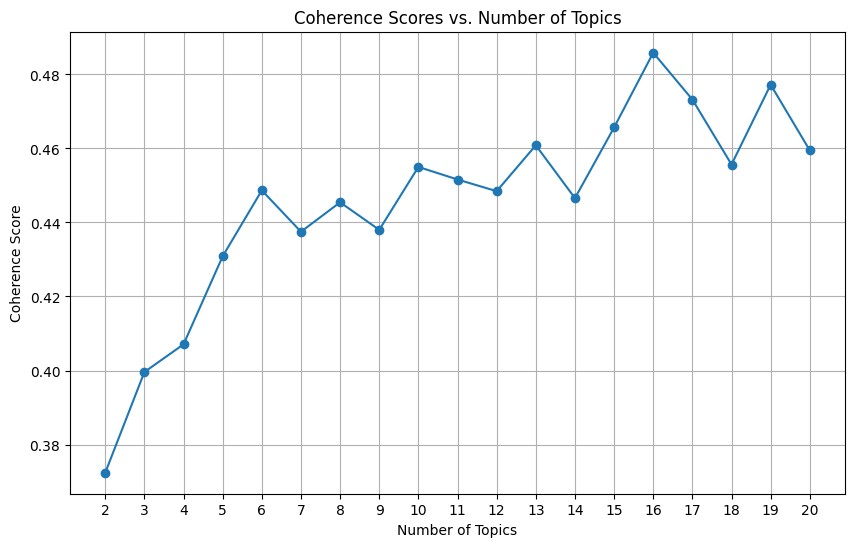

(0, '0.011*"stock" + 0.008*"market" + 0.006*"company" + 0.006*"time" + 0.006*"like" + 0.006*"day" + 0.005*"one" + 0.005*"tech" + 0.005*"nasdaq" + 0.004*"trading"')
(1, '0.013*"market" + 0.011*"week" + 0.009*"year" + 0.007*"could" + 0.007*"last" + 0.006*"rate" + 0.006*"investor" + 0.006*"might" + 0.006*"fed" + 0.005*"month"')
(2, '0.022*"year" + 0.022*"stock" + 0.017*"earnings" + 0.016*"industry" + 0.015*"zacks" + 0.014*"estimate" + 0.013*"nasdaq" + 0.011*"share" + 0.011*"company" + 0.010*"investor"')
(3, '0.035*"nvidia" + 0.016*"amd" + 0.015*"year" + 0.013*"share" + 0.012*"chip" + 0.012*"revenue" + 0.012*"intel" + 0.010*"company" + 0.010*"gaming" + 0.010*"analyst"')
(4, '0.015*"company" + 0.011*"technology" + 0.011*"nasdaq" + 0.009*"intel" + 0.009*"driving" + 0.008*"car" + 0.008*"nvidia" + 0.006*"new" + 0.006*"also" + 0.006*"apple"')
(5, '0.015*"china" + 0.011*"said" + 0.010*"percent" + 0.008*"trade" + 0.007*"market" + 0.007*"company" + 0.007*"billion" + 0.006*"year" + 0.006*"trump" + 

In [23]:
LDA_model, LDA_topics = train_topic_model(train_data_v2, model_type='LDA', max_topics=20)

# Print topics
for topic in LDA_topics:
    print(topic)

## Iteration 3

### LDA

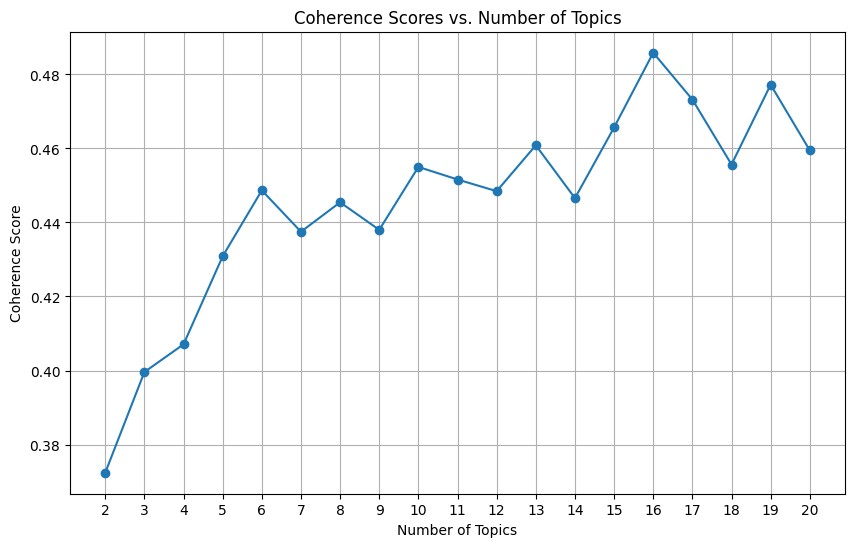

(0, '0.011*"stock" + 0.008*"market" + 0.006*"company" + 0.006*"time" + 0.006*"like" + 0.006*"day" + 0.005*"one" + 0.005*"tech" + 0.005*"nasdaq" + 0.004*"trading"')
(1, '0.013*"market" + 0.011*"week" + 0.009*"year" + 0.007*"could" + 0.007*"last" + 0.006*"rate" + 0.006*"investor" + 0.006*"might" + 0.006*"fed" + 0.005*"month"')
(2, '0.022*"year" + 0.022*"stock" + 0.017*"earnings" + 0.016*"industry" + 0.015*"zacks" + 0.014*"estimate" + 0.013*"nasdaq" + 0.011*"share" + 0.011*"company" + 0.010*"investor"')
(3, '0.035*"nvidia" + 0.016*"amd" + 0.015*"year" + 0.013*"share" + 0.012*"chip" + 0.012*"revenue" + 0.012*"intel" + 0.010*"company" + 0.010*"gaming" + 0.010*"analyst"')
(4, '0.015*"company" + 0.011*"technology" + 0.011*"nasdaq" + 0.009*"intel" + 0.009*"driving" + 0.008*"car" + 0.008*"nvidia" + 0.006*"new" + 0.006*"also" + 0.006*"apple"')
(5, '0.015*"china" + 0.011*"said" + 0.010*"percent" + 0.008*"trade" + 0.007*"market" + 0.007*"company" + 0.007*"billion" + 0.006*"year" + 0.006*"trump" + 

In [24]:
LDA_model, LDA_topics = train_topic_model(train_data_v3, model_type='LDA', max_topics=20)

# Print topics
for topic in LDA_topics:
    print(topic)

## Iteration 4

### LDA

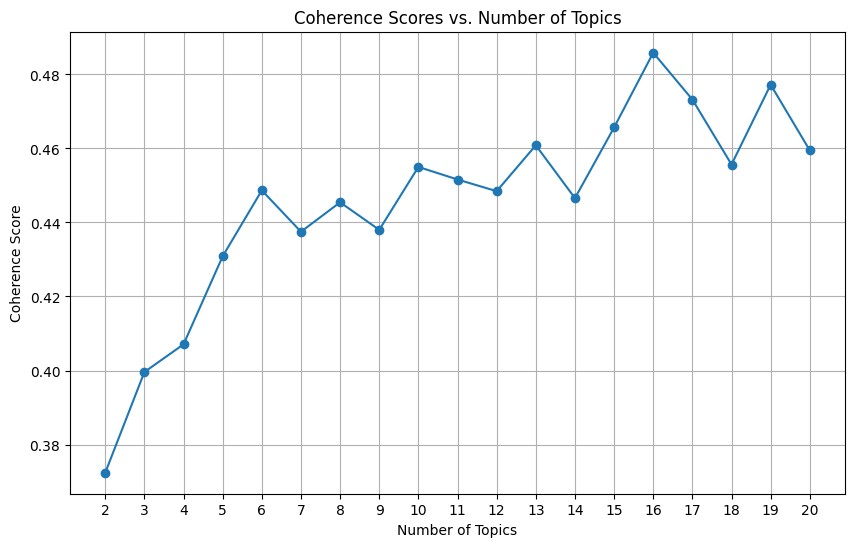

(0, '0.011*"stock" + 0.008*"market" + 0.006*"company" + 0.006*"time" + 0.006*"like" + 0.006*"day" + 0.005*"one" + 0.005*"tech" + 0.005*"nasdaq" + 0.004*"trading"')
(1, '0.013*"market" + 0.011*"week" + 0.009*"year" + 0.007*"could" + 0.007*"last" + 0.006*"rate" + 0.006*"investor" + 0.006*"might" + 0.006*"fed" + 0.005*"month"')
(2, '0.022*"year" + 0.022*"stock" + 0.017*"earnings" + 0.016*"industry" + 0.015*"zacks" + 0.014*"estimate" + 0.013*"nasdaq" + 0.011*"share" + 0.011*"company" + 0.010*"investor"')
(3, '0.035*"nvidia" + 0.016*"amd" + 0.015*"year" + 0.013*"share" + 0.012*"chip" + 0.012*"revenue" + 0.012*"intel" + 0.010*"company" + 0.010*"gaming" + 0.010*"analyst"')
(4, '0.015*"company" + 0.011*"technology" + 0.011*"nasdaq" + 0.009*"intel" + 0.009*"driving" + 0.008*"car" + 0.008*"nvidia" + 0.006*"new" + 0.006*"also" + 0.006*"apple"')
(5, '0.015*"china" + 0.011*"said" + 0.010*"percent" + 0.008*"trade" + 0.007*"market" + 0.007*"company" + 0.007*"billion" + 0.006*"year" + 0.006*"trump" + 

In [25]:
LDA_model, LDA_topics = train_topic_model(train_data_v4, model_type='LDA', max_topics=20)

# Print topics
for topic in LDA_topics:
    print(topic)

## Evaluation

### Qualitative

### Quantitative

## Output of Final Topic Model